In [118]:
from lib.csv_scores import *
import matplotlib.pyplot as plt
from protestDB import cursor

## Lets read in the data

In [119]:
UCLA_csv = "../misc/pairwise_annot.csv"
luca_csv = "../misc/pairwise_annot_luca_ecb.csv"
all_csv  = "../misc/pairwise_annot_alldata.csv"

In [120]:
df_UCLA_raw = pd.read_csv(UCLA_csv, index_col=0)
df_luca_raw = pd.read_csv(luca_csv, index_col=0)
df_all_raw = pd.read_csv(all_csv, index_col=0)

## First, lets process image raw scores

In [121]:
UCLA_csv_out = "output/UCLA_raw_scores.csv"
luca_csv_out = "output/luca_1000_raw_scores.csv"
all_csv_out = "output/all_raw_scores.csv"

if not os.path.exists(all_csv_out):
    GenerateChoixScores(df_all_raw, all_csv_out)
    
if not os.path.exists(UCLA_csv_out):
    GenerateChoixScores(df_UCLA_raw, UCLA_csv_out)
    
if not os.path.exists(luca_csv_out):
    GenerateChoixScores(df_luca_raw, luca_csv_out)

In [122]:
# read scores and mini max them
df_all = MinMax(ReadScoresFromCsv(all_csv_out), "violence")
df_UCLA = MinMax(ReadScoresFromCsv(UCLA_csv_out), "violence")
df_luca = MinMax(ReadScoresFromCsv(luca_csv_out), "violence")

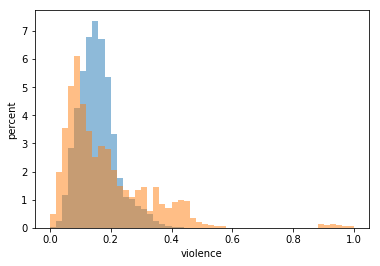

In [123]:
# check distribution
plt.hist(df_UCLA['violence'], 50, label = "UCLA", alpha=0.5, density = 1)
plt.hist(df_luca['violence'], 50, label = "luca", alpha=0.5, density = 1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

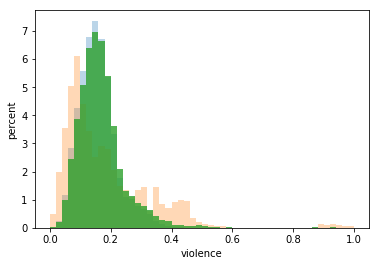

In [124]:
# Check against all, where all is all the scores computed together:
plt.hist(df_UCLA['violence'], 50, label = "UCLA", alpha=0.3, density = 1)
plt.hist(df_luca['violence'], 50, label = "luca", alpha=0.3, density = 1)
plt.hist(df_all['violence'], 50, label = "all", alpha=.8, density=1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

Below here we use the Kolmogorov–Smirnov to evaluate if both distributions come from the same population. The interpretation of the p value according to https://www.graphpad.com/guides/prism/7/statistics/interpreting_results_kolmogorov-smirnov_test.htm?toc=0&printWindow is as follows:

"If the two samples were randomly sampled from identical populations, what is the probability that the two cumulative frequency distributions would be as far apart as observed?"

In [125]:
print(stats.ks_2samp(df_UCLA['violence'], df_luca['violence']).pvalue)

7.228869847691746e-27


Uuuh, it does not look like they come from the same distribution

## Now, lets do the same considering we clip it

In [126]:
ucla_cut = .43
luca_cut = .63
df_UCLA_clipped = MinMax(ClipValues(df_UCLA, ucla_cut), 'violence')
df_luca_clipped = MinMax(ClipValues(df_luca, luca_cut), 'violence')
df_all_clipped = MinMax(ClipValues(df_all, ucla_cut), 'violence')

In [127]:
luca_cut_imgs = len(df_luca[df_luca['violence'] > luca_cut])
luca_rate = luca_cut_imgs / len(df_luca)
ucla_cut_imgs = len(df_UCLA[df_UCLA['violence'] > ucla_cut])
ucla_rate = ucla_cut_imgs / len(df_UCLA)
print(luca_rate, ucla_rate, luca_cut_imgs, ucla_cut_imgs)

0.012 0.0004288532464190754 12 5


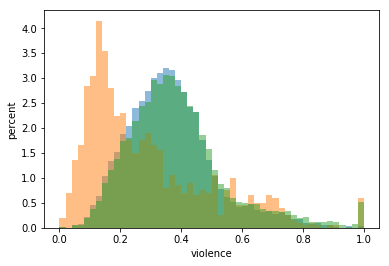

In [128]:
# check distribution
plt.hist(df_UCLA_clipped['violence'], 50, label = "UCLA", alpha=0.5, density = 1)
plt.hist(df_luca_clipped['violence'], 50, label = "luca", alpha=0.5, density = 1)
plt.hist(df_all_clipped['violence'], 50, label = 'all', alpha=.5, density = 1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

In [129]:
print(stats.ks_2samp(df_UCLA_clipped['violence'], df_luca_clipped['violence']).pvalue)

4.601591382341375e-102


Uhhhh x2, even worst. Definitely not the same distribution

## All right, now lets have a look at the effect of clipping

The aim here is to investigate if we loose precision by clipping images. In order to do that, we visually inspect the differences between the images with labels bigger than the cut point, and images slightly below the cut point

### First lets look at UCLA

In [130]:
UCLA_very_violent = df_UCLA[df_UCLA['violence'] > 0.43]
UCLA_cut_point = df_UCLA[(df_UCLA['violence'] <= 0.43) & (df_UCLA['violence'] >= 0.38) ]

In [131]:
images_dir = "../images"
images_to_print = 5

### Ivestigating mages close to 1

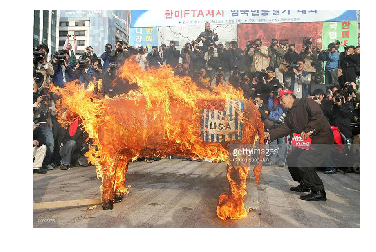

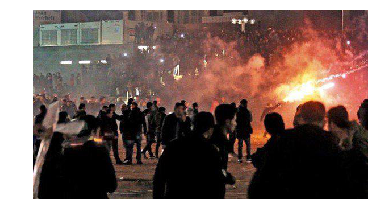

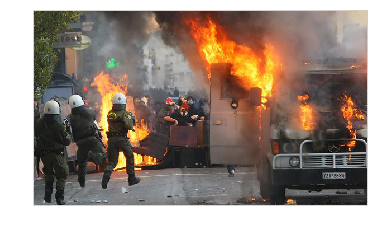

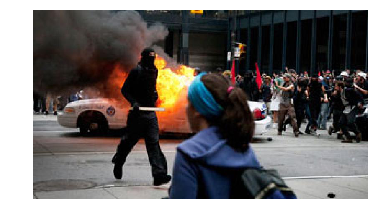

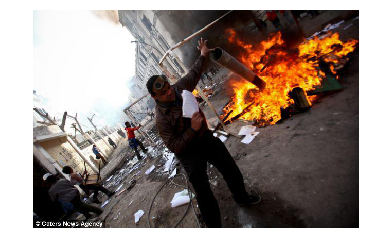

In [132]:
img_paths = UCLA_very_violent['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Ivestigating mages close to the cut point

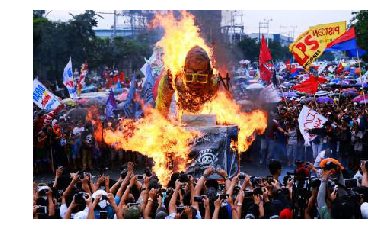

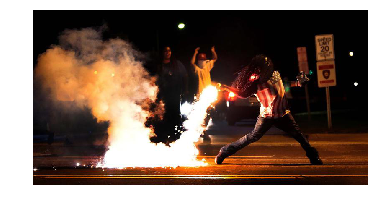

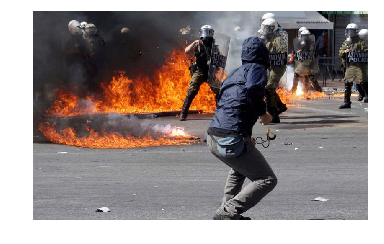

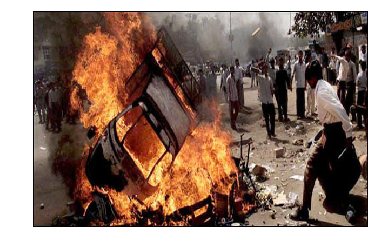

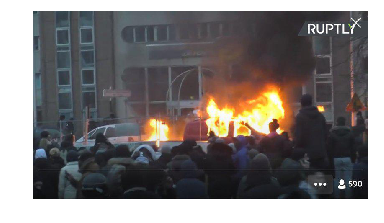

In [133]:
img_paths = UCLA_cut_point['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Images close to 1 do not seem to differ much from the images that are close to our clipping point. This indicates that we probably should treat them as outliners in terms of scores. In other words, pulling their scores closer to each other should not cause us a lost in precision in the range of violence

### Now lets look at Luca data

In [134]:
luca_very_violent = df_luca[df_luca['violence'] > 0.6]
luca_cut_point = df_luca[(df_luca['violence'] <= 0.6) & (df_luca['violence'] >= 0.5) ]

### Ivestigating mages close to 1

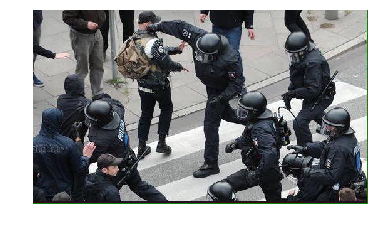

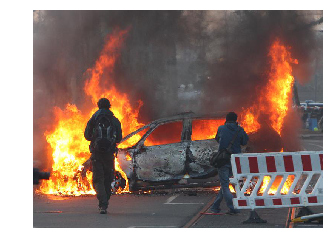

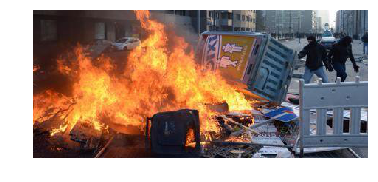

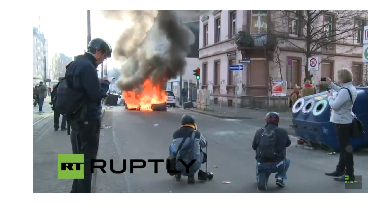

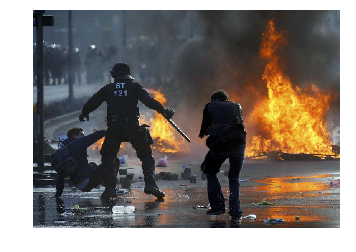

In [135]:
img_paths = luca_very_violent['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Ivestigating mages close to the cut point

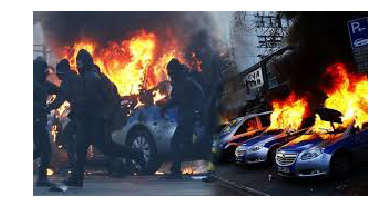

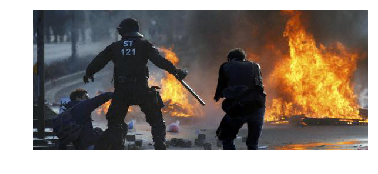

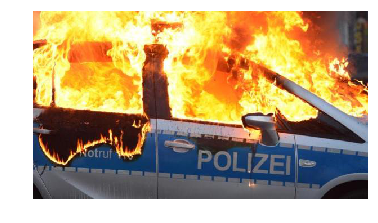

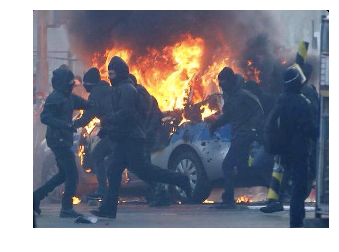

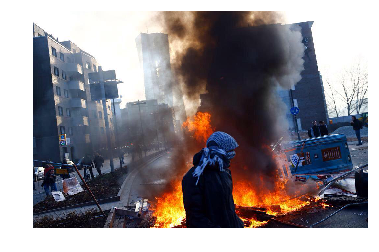

In [136]:
img_paths = luca_cut_point['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

It seems that the statement above also holds for Luca's dataset

# Joined scores

### Load the data

In [137]:
ITU_UCLA_sample = "../misc/pairwise_annot_intersection_200_UCLA_ITU.csv"
df_ITU_UCLA_sample_raw = pd.read_csv(ITU_UCLA_sample, index_col=0)

In [138]:
# combine data frame scores for ITU + UCLA + UCLA_ITU Sample
df_combined_raw = df_ITU_UCLA_sample_raw.append([df_UCLA_raw, df_luca_raw])
print((len(df_combined_raw) == len(df_ITU_UCLA_sample_raw) + len(df_UCLA_raw) + len(df_luca_raw)))

True


### Generate scores

In [139]:
ITU_UCLA_combined_out = "output/ITU_UCLA_combined_raw_scores.csv"
    
if not os.path.exists(ITU_UCLA_combined_out):
    GenerateChoixScores(df_combined_raw, ITU_UCLA_combined_out)

In [140]:
# read scores and mini max them
df_ITU_UCLA_combined = MinMax(ReadScoresFromCsv(ITU_UCLA_combined_out), "violence")

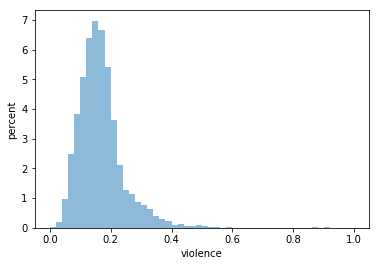

In [141]:
# check distribution
plt.hist(df_ITU_UCLA_combined['violence'], 50, alpha=0.5, density = 1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

In [142]:
# What is the percentage of observations with label above 0.43 on the combined dataset?
percen_43 = (len(df_ITU_UCLA_combined[df_ITU_UCLA_combined['violence'] > 0.43]) / len(df_ITU_UCLA_combined)) * 100
# What is the percentage of observations with label above 0.6 on the combined dataset?
percen_60 = (len(df_ITU_UCLA_combined[df_ITU_UCLA_combined['violence'] > 0.6]) / len(df_ITU_UCLA_combined)) * 100

print("percentage above .43 is ", percen_43, "%", " percentage above .6 is ", percen_60, "%")

percentage above .43 is  0.9874397661742633 %  percentage above .6 is  0.13429180819969982 %


In [143]:
# What is the percentage of observations with label above 0.43 in the original UCLA?
percen_43_UCLA = (len(df_UCLA[df_UCLA['violence'] > 0.43]) / len(df_UCLA)) * 100
print("percentage above .43 is ", percen_43_UCLA, "%")

percentage above .43 is  0.042885324641907537 %


Since the original clipping was done visually, it gets a bit tricky now to do the same since we have a tail that is more spread out

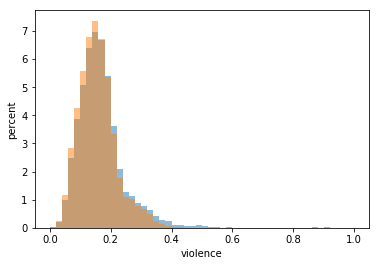

In [144]:
# check it against original UCLA
plt.hist(df_ITU_UCLA_combined['violence'], 50, label = "UCLA", alpha=0.5, density = 1)
plt.hist(df_UCLA['violence'], 50, label = "UCLA", alpha=0.5, density = 1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

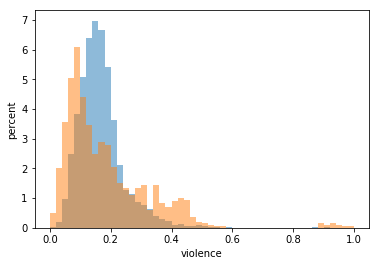

In [145]:
# check it against original ITU
plt.hist(df_ITU_UCLA_combined['violence'], 50, label = "UCLA", alpha=0.5, density = 1)
plt.hist(df_luca['violence'], 50, label = "luca", alpha=0.5, density = 1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

### Effect of clipping in different points

In [146]:
images_dir = "../images"
images_to_print = 5

In [147]:
df_ITU_UCLA_combined_close1 = df_ITU_UCLA_combined[df_ITU_UCLA_combined['violence'] > 0.8]
df_ITU_UCLA_combined_closecut43 = df_ITU_UCLA_combined[(df_ITU_UCLA_combined['violence'] <= 0.43) & (df_ITU_UCLA_combined['violence'] >= 0.43 - 0.05) ]
df_ITU_UCLA_combined_closecut6 = df_ITU_UCLA_combined[(df_ITU_UCLA_combined['violence'] <= 0.6) & (df_ITU_UCLA_combined['violence'] >= 0.6 - 0.05) ]


** CLOSE TO 1 **

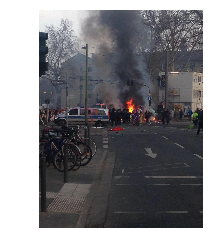

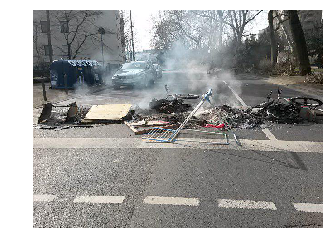

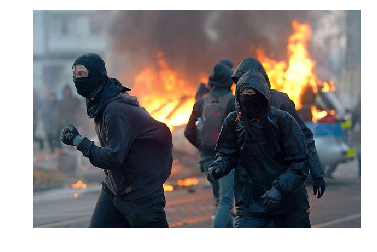

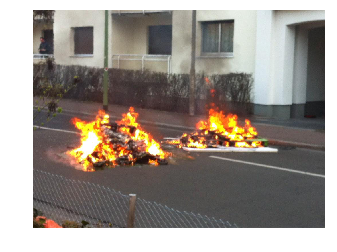

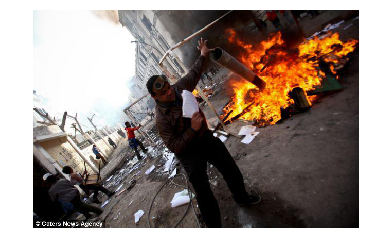

In [148]:
img_paths = df_ITU_UCLA_combined_close1['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

It is worring that our images close to 1 are only in our dataset. Perhaps 200 comparisons are not enough to force the scores to adapt through transitivity

** CLOSE TO .6 **

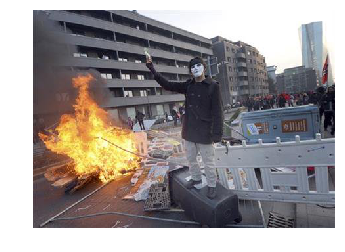

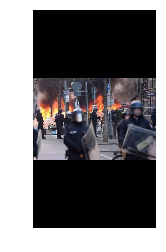

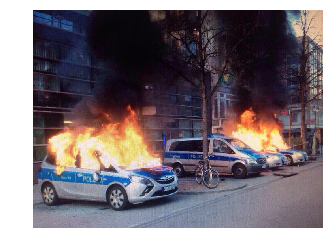

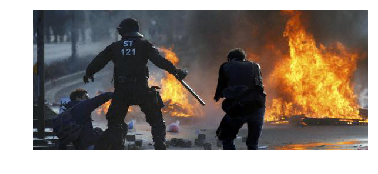

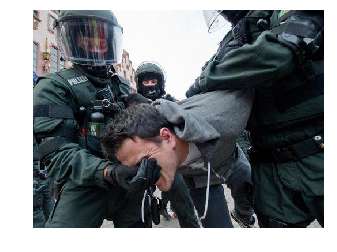

In [149]:
img_paths = df_ITU_UCLA_combined_closecut6['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Clipping at this point seems safe, but still images are only from our dataset

** CLOSE TO .43 **

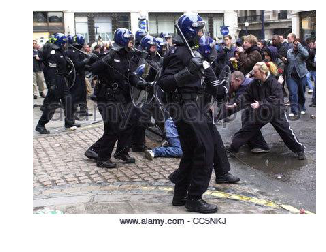

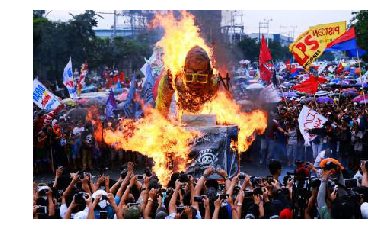

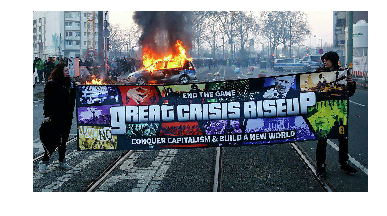

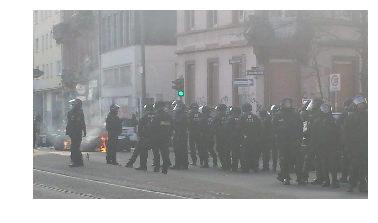

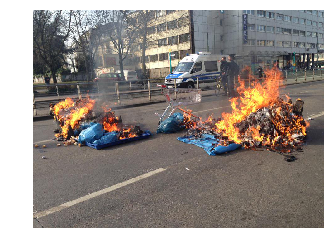

In [150]:
img_paths = df_ITU_UCLA_combined_closecut43['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Now we see UCLA images, and clipping still seems reasonable

**Analysing now how many UCLA images are more violent than 0.43 **

In [156]:
df_bigger_4_combined = df_ITU_UCLA_combined[df_ITU_UCLA_combined['violence'] >= 0.4]

In [157]:
print(len(df_bigger_4_combined[df_bigger_4_combined['fname'].str.startswith('train')]) + len(df_bigger_4_combined[df_bigger_4_combined['fname'].str.startswith('test')]), " images come from the UCLA dataset and are more than 0.4 violent")

20  images come from the UCLA dataset and are more than 0.4 violent


In [158]:
print("versus ", len(df_bigger_4_combined), " from ITU")

versus  161  from ITU


In [159]:
print ("before, UCLA had ", len(df_UCLA[df_UCLA['violence'] >= 0.4]))

before, UCLA had  16


However, our images seem to dominate the violent scenarios, which indicate that transitivity is probably not enough given our sample size of the combined sets

### Lets check some concrete examples of how much scores changed

First, we read in and get the filenames for the images that were sampled in the combined dataset comparison

In [63]:
# read the images that were sampled and get their fnames
pc = cursor.ProtestCursor()
images = pc.getLabelledImagesAndNonProtest(label_source="combined").reset_index()

df_sampled_images = pd.read_csv("../mturk/sample-luca-ucla.txt", header = None, names =  ['imageHASH'])
d_sampled_images_names = pd.DataFrame(pd.merge(images, df_sampled_images, how='inner', on='imageHASH')['name'])
d_sampled_images_names = d_sampled_images_names.rename(index=str, columns={"name": "fname"})
d_sampled_images_names

fname
0           test-00420.jpg
1           test-01364.jpg
2           test-01906.jpg
3           test-02597.jpg
4           test-02791.jpg
5           test-03087.jpg
6           test-03159.jpg
7           test-03203.jpg
8           test-03816.jpg
9           test-03953.jpg
10          test-04183.jpg
11          test-04691.jpg
12          test-04772.jpg
13          test-06513.jpg
14          test-07125.jpg
15          test-07353.jpg
16          test-07714.jpg
17          test-08016.jpg
18          test-08022.jpg
19          test-08151.jpg
20         train-00254.jpg
21         train-00576.jpg
22         train-00757.jpg
23         train-00866.jpg
24         train-01248.jpg
25         train-01722.jpg
26         train-02920.jpg
27         train-03670.jpg
28         train-03929.jpg
29         train-04130.jpg
..                     ...
170   1f0cb49b5f3d3f3d.png
171   72733261b09399d1.png
172  8024cc948ca2a594.jpeg
173  cdcce1635959beb2.jpeg
174  6f3d2ccdcc646a6e.jpeg
175  5de72ba98f62f3a3.jpeg
176  63e7c6c86872345c.jpeg
177  f37164a4d456dbf8.jpeg
178  65b5cb8a0a4a465a.jpeg
179  607c3cf435e898bc.jpeg
180  c645c3e2b69fc0f0.jpeg
181  808080a03934250b.jpeg
182  8eacb434cd726264.jpeg
183  3030321292b391ad.jpeg
184  ee76631898b41d49.jpeg
185  79e9cc9c86849c92.jpeg
186  5a3465c949651fcf.jpeg
187  6178783164f2f219.jpeg
188  9b593939f9f9f155.jpeg
189  c4c13c06f271c990.jpeg
190         test-00651.jpg
191         test-03435.jpg
192        train-00386.jpg
193        train-08551.jpg
194        train-13645.jpg
195        train-13909.jpg
196        train-16388.jpg
197        train-23620.jpg
198        train-25067.jpg
199        train-26230.jpg

[200 rows x 1 columns]

In [67]:
original_ITU_new = pd.merge(df_luca, df_ITU_UCLA_combined, how='inner', on=['fname'])
original_ITU_new['diff'] = np.abs(original_ITU_new['violence_x'] - original_ITU_new['violence_y'])

original_ITU_new

violence_x                  fname  violence_y      diff
0      0.372350  c74683e339b9b830.jpeg    0.432168  0.059818
1      0.156410  9a51313574c545cb.jpeg    0.219775  0.063365
2      0.298932  044d59694f1a3b0a.jpeg    0.365340  0.066408
3      0.122438   72733261b09399d1.png    0.169001  0.046563
4      0.208902  070f0c0d5d142f00.jpeg    0.275108  0.066206
5      0.401406  2dc9ccf4545595bd.jpeg    0.476960  0.075554
6      0.119420  d859b6d2c149a2a9.jpeg    0.177447  0.058026
7      0.049873  4d60525c3c3e3e66.jpeg    0.105076  0.055203
8      0.171005  fce7e5b55a9535d6.jpeg    0.233360  0.062355
9      0.131814  662e0c63a377fe7e.jpeg    0.196378  0.064563
10     0.281277  0000ccc848368900.jpeg    0.351749  0.070472
11     0.222527  f2d2b1b1cdcc2931.jpeg    0.289293  0.066766
12     0.157253  4146c73716b5b534.jpeg    0.217768  0.060515
13     0.427369  9539796523a32722.jpeg    0.470463  0.043094
14     0.116620  88892f2733e7e3c7.jpeg    0.175657  0.059037
15     0.241738  061a512528898981.jpeg    0.308147  0.066408
16     0.202948  c684525666868a92.jpeg    0.274555  0.071607
17     0.066131  375f7c1e33d5cc68.jpeg    0.121401  0.055270
18     0.055655  1cf421d112d6ccda.jpeg    0.113092  0.057437
19     0.099198  1e3cd0d83a55cdb2.jpeg    0.157905  0.058708
20     0.189059  28130d276def6e7d.jpeg    0.254448  0.065389
21     0.068082  06646168d6dacc81.jpeg    0.125442  0.057361
22     0.158630  09899d9a3267c823.jpeg    0.220264  0.061635
23     0.102925  6677f3cd3e7ef6fe.jpeg    0.161799  0.058874
24     0.101253  d8dadc7c3e9c81ab.jpeg    0.159327  0.058074
25     0.070208  47731ad387878383.jpeg    0.129948  0.059740
26     0.080722  797ed0c0e2d746d8.jpeg    0.139021  0.058300
27     0.152920  e0e86ae4b266e599.jpeg    0.221316  0.068397
28     0.140411  f1d9b5a4eb692b6b.jpeg    0.199914  0.059503
29     0.201972  c4c13c06f271c990.jpeg    0.286703  0.084731
..          ...                    ...         ...       ...
970    0.140225  09e183d37b6f4d4e.jpeg    0.197264  0.057039
971    0.170497  04763f1793071933.jpeg    0.241211  0.070714
972    0.209060  938fcec35141d194.jpeg    0.264318  0.055258
973    0.174182  565ee81a95b5e424.jpeg    0.233253  0.059071
974    0.087451  7262e2e1f0f9acb2.jpeg    0.147683  0.060232
975    0.375439  38b8b0e0e50384e3.jpeg    0.449258  0.073818
976    0.067787  a4c4c28ce1e26060.jpeg    0.124585  0.056798
977    0.128883  f4f4f0f967f8193c.jpeg    0.187345  0.058462
978    0.156086  3d3d1f6b2f3c6c2c.jpeg    0.212058  0.055973
979    0.091483  1715171f3dcab42b.jpeg    0.149426  0.057942
980    0.358593  a6c6c6be343898c5.jpeg    0.427613  0.069021
981    0.147542  eccce8b151c35134.jpeg    0.210204  0.062662
982    0.300168  e8f0c20f31edbeb8.jpeg    0.371245  0.071076
983    0.112498  edcbb3336b49b326.jpeg    0.179899  0.067401
984    0.038166  fcf8fecefcb466b6.jpeg    0.098306  0.060140
985    0.502449  44004d4893990091.jpeg    0.588749  0.086299
986    0.208385  d0e8e8f8b86a484c.jpeg    0.272634  0.064248
987    0.421923  a72f4b591b4b5a52.jpeg    0.497630  0.075707
988    0.070885  485cb79f9fe88aa6.jpeg    0.127888  0.057003
989    0.218349  3434799af2e20280.jpeg    0.283610  0.065260
990    0.048849  98787cec62269686.jpeg    0.106878  0.058028
991    0.113065  0e0e0e5627abdb81.jpeg    0.176641  0.063576
992    0.049131  71e15112383cae55.jpeg    0.106153  0.057023
993    0.252096  db1ddb579747cf99.jpeg    0.318897  0.066800
994    0.421890  23c2ecee6f7c34b6.jpeg    0.492364  0.070474
995    0.352836  6c3e3a79f9f2f878.jpeg    0.426539  0.073703
996    0.240404  711747e969e8c201.jpeg    0.241244  0.000839
997    0.024631  313339f939a6a343.jpeg    0.072540  0.047909
998    0.210144  5833339b26761ada.jpeg    0.278331  0.068187
999    0.468443  9f9bb191d999ccdc.jpeg    0.545978  0.077535

[1000 rows x 4 columns]

In [84]:
original_UCLA_new = pd.merge(df_UCLA, df_ITU_UCLA_combined, how='inner', on=['fname'])
original_UCLA_new['diff'] = np.abs(original_UCLA_new['violence_x'] - original_UCLA_new['violence_y'])

original_UCLA_new

violence_x            fname  violence_y      diff
0        0.167528  train-18039.jpg    0.172059  0.004532
1        0.179263  train-14060.jpg    0.183959  0.004696
2        0.109879  train-15276.jpg    0.112715  0.002836
3        0.214008  train-11001.jpg    0.219503  0.005495
4        0.179158  train-09109.jpg    0.183678  0.004520
5        0.182691   test-01319.jpg    0.187596  0.004905
6        0.085104   test-05085.jpg    0.087605  0.002500
7        0.136910  train-00308.jpg    0.140554  0.003644
8        0.195505  train-32019.jpg    0.200388  0.004883
9        0.139078   test-08072.jpg    0.142484  0.003406
10       0.100372  train-21998.jpg    0.102138  0.001767
11       0.144013   test-03376.jpg    0.147795  0.003782
12       0.216610   test-03104.jpg    0.223620  0.007010
13       0.057345  train-21042.jpg    0.058780  0.001435
14       0.202199  train-04905.jpg    0.207967  0.005768
15       0.090283  train-32037.jpg    0.092667  0.002384
16       0.217602  train-01568.jpg    0.223305  0.005702
17       0.093006  train-13505.jpg    0.095272  0.002266
18       0.188618  train-23800.jpg    0.193505  0.004887
19       0.152780  train-32208.jpg    0.156685  0.003906
20       0.281714  train-02566.jpg    0.289046  0.007332
21       0.211392  train-13440.jpg    0.216891  0.005499
22       0.092797   test-05739.jpg    0.095077  0.002280
23       0.207149  train-28951.jpg    0.212296  0.005147
24       0.178274  train-12994.jpg    0.182720  0.004446
25       0.110917  train-19026.jpg    0.113660  0.002743
26       0.082445  train-04465.jpg    0.084472  0.002027
27       0.218683  train-14902.jpg    0.224294  0.005611
28       0.176407  train-27288.jpg    0.180951  0.004545
29       0.192020  train-03510.jpg    0.196873  0.004853
...           ...              ...         ...       ...
11629    0.178093  train-08928.jpg    0.182689  0.004595
11630    0.177922  train-18058.jpg    0.182547  0.004625
11631    0.152173  train-10180.jpg    0.156308  0.004135
11632    0.211570  train-18659.jpg    0.217602  0.006032
11633    0.159821  train-11795.jpg    0.164035  0.004214
11634    0.144687  train-22165.jpg    0.148362  0.003676
11635    0.146058  train-07257.jpg    0.149855  0.003797
11636    0.163662  train-04575.jpg    0.167750  0.004088
11637    0.354590  train-00104.jpg    0.363512  0.008923
11638    0.142229   test-03634.jpg    0.146816  0.004587
11639    0.115909  train-27636.jpg    0.118964  0.003055
11640    0.153878  train-20307.jpg    0.157894  0.004017
11641    0.192279  train-28862.jpg    0.197290  0.005011
11642    0.122882  train-03448.jpg    0.126186  0.003304
11643    0.059200  train-01716.jpg    0.060899  0.001699
11644    0.075081  train-29929.jpg    0.076940  0.001859
11645    0.367068  train-11525.jpg    0.376945  0.009877
11646    0.205696  train-09919.jpg    0.211180  0.005484
11647    0.132880  train-00795.jpg    0.135972  0.003092
11648    0.110666  train-13512.jpg    0.113619  0.002953
11649    0.102190   test-01364.jpg    0.120257  0.018067
11650    0.064015   test-06475.jpg    0.065663  0.001648
11651    0.280473  train-31318.jpg    0.287708  0.007235
11652    0.145168  train-14401.jpg    0.148723  0.003555
11653    0.087065  train-19333.jpg    0.088935  0.001870
11654    0.044440  train-07011.jpg    0.045883  0.001443
11655    0.305083  train-28647.jpg    0.313249  0.008166
11656    0.047403  train-29601.jpg    0.048614  0.001212
11657    0.207329  train-16439.jpg    0.212681  0.005352
11658    0.186166  train-01526.jpg    0.190985  0.004819

[11659 rows x 4 columns]

In [165]:
# average change of scores 
print ("general: ",
       "ITU: ", np.mean(original_ITU_new['diff']),
       " UCLA: ", np.mean(original_UCLA_new['diff']))

print ( " >= 0.4: ", 
       " ITU: ", np.mean(original_ITU_new[original_ITU_new['violence_x'] >= 0.4]['diff']),
       " UCLA: ", np.mean(original_UCLA_new[original_UCLA_new['violence_x'] >= 0.4]['diff']))

print ( " < 0.4: ", 
       " ITU: ", np.mean(original_ITU_new[original_ITU_new['violence_x'] < 0.4]['diff']),
       " UCLA: ", np.mean(original_UCLA_new[original_UCLA_new['violence_x'] < 0.4]['diff']))

general:  ITU:  0.06220538381154474  UCLA:  0.004268086180607033
 >= 0.4:   ITU:  0.06937959057653612  UCLA:  0.037164819539140914
 < 0.4:   ITU:  0.061521751841605785  UCLA:  0.004222878954485196


In [166]:
# average change of scores in the images that were sampled
original_ITU_new_sampled = pd.merge(original_ITU_new, d_sampled_images_names, how='inner', on=['fname'])
original_UCLA_new_sampled = pd.merge(original_UCLA_new, d_sampled_images_names, how='inner', on=['fname'])

print ("general: ",
       "ITU: ", np.mean(original_ITU_new_sampled['diff']),
       " UCLA: ", np.mean(original_UCLA_new_sampled['diff']))

print ( " >= 0.4: ", 
       " ITU: ", np.mean(original_ITU_new_sampled[original_ITU_new_sampled['violence_x'] >= 0.4]['diff']),
       " UCLA: ", np.mean(original_UCLA_new_sampled[original_UCLA_new_sampled['violence_x'] >= 0.4]['diff']))

print ( " < 0.4: ", 
       " ITU: ", np.mean(original_ITU_new_sampled[original_ITU_new_sampled['violence_x'] < 0.4]['diff']),
       " UCLA: ", np.mean(original_UCLA_new_sampled[original_UCLA_new_sampled['violence_x'] < 0.4]['diff']))


general:  ITU:  0.06709106741482283  UCLA:  0.019309867712218133
 >= 0.4:   ITU:  0.13225290545405255  UCLA:  nan
 < 0.4:   ITU:  0.06064649002632758  UCLA:  0.019309867712218133


In [167]:
# average change of scores in the images that were not sampled
original_ITU_new_not_sampled = original_ITU_new[~ original_ITU_new['fname'].isin(original_ITU_new_sampled['fname'])]
original_UCLA_new_not_sampled = original_UCLA_new[~ original_UCLA_new['fname'].isin(original_UCLA_new_sampled['fname'])]


print ("general: ",
       "ITU: ", np.mean(original_ITU_new_not_sampled['diff']), 
       " UCLA: ", np.mean(original_UCLA_new_not_sampled['diff']))


print ( " >= 0.4: ", 
       " ITU: ", np.mean(original_ITU_new_not_sampled[original_ITU_new_not_sampled['violence_x'] >= 0.4]['diff']),
       " UCLA: ", np.mean(original_UCLA_new_not_sampled[original_UCLA_new_not_sampled['violence_x'] >= 0.4]['diff']))

print ( " < 0.4: ", 
       " ITU: ", np.mean(original_ITU_new_not_sampled[original_ITU_new_not_sampled['violence_x'] < 0.4]['diff']),
       " UCLA: ", np.mean(original_UCLA_new_not_sampled[original_UCLA_new_not_sampled['violence_x'] < 0.4]['diff']))

general:  ITU:  0.061662530077847166  UCLA:  0.004137955706244103
 >= 0.4:   ITU:  0.062124977321438075  UCLA:  0.037164819539140914
 < 0.4:   ITU:  0.06161864822261591  UCLA:  0.004092176461565393


**Manual inspection**

In [45]:
original_ITU_new[original_ITU_new['violence_x'] > 0.5]

violence_x                  fname  violence_y          diff
147    0.910823  656d0d5575f3e274.jpeg    0.906312  4.510762e-03
206    0.961266  195b92ca2a270626.jpeg    0.455088  5.061778e-01
240    0.895668  eee0e1b3929b9adc.jpeg    0.883214  1.245412e-02
332    0.924982   9943534242484a4a.png    0.914637  1.034549e-02
433    0.558154  7969c94b656e3670.jpeg    0.640286  8.213265e-02
437    0.953538  c1c3a626b67767c7.jpeg    0.953975  4.370149e-04
447    0.939234  94d6b64a8c940b20.jpeg    0.931773  7.460371e-03
540    0.898530  b18119479772428d.jpeg    0.378905  5.196251e-01
541    0.905143  8fcbaf8b68e58482.jpeg    0.892940  1.220298e-02
581    0.518036  a5a636a6a637f567.jpeg    0.588207  7.017184e-02
589    0.934671  8e6ad2bbbbb19199.jpeg    0.927877  6.794140e-03
638    0.520427  94545696f1e81c98.jpeg    0.568283  4.785661e-02
694    0.946990  c7e7e76602cbf924.jpeg    0.940466  6.524722e-03
705    0.886600  68e0f0c8c8020105.jpeg    0.872025  1.457431e-02
760    1.000000  9f06662733333333.jpeg    1.000000  2.220446e-16
871    0.567590   3e1331319939143c.png    0.651373  8.378352e-02
874    0.532498  87c7c7c7a4e56c6c.jpeg    0.583056  5.055742e-02
943    0.510771  c8e092111969a9e9.jpeg    0.547680  3.690870e-02
985    0.502449  44004d4893990091.jpeg    0.588749  8.629945e-02

Images that had been sample in the comparison seem to have a big change in their scores. For instance:
* 195b92ca2a270626.jpeg
* b18119479772428d.jpeg

While images that were not sampled, seem to remain with a pretty similar score than in the original run: 

* 656d0d5575f3e274.jpeg 	
* eee0e1b3929b9adc.jpeg
* 9f06662733333333.jpeg

Does this change in not so violent images?

In [44]:
original_ITU_new[original_ITU_new['violence_x'] < 0.3]

violence_x                  fname  violence_y
1      0.156410  9a51313574c545cb.jpeg    0.219775
2      0.298932  044d59694f1a3b0a.jpeg    0.365340
3      0.122438   72733261b09399d1.png    0.169001
4      0.208902  070f0c0d5d142f00.jpeg    0.275108
6      0.119420  d859b6d2c149a2a9.jpeg    0.177447
7      0.049873  4d60525c3c3e3e66.jpeg    0.105076
8      0.171005  fce7e5b55a9535d6.jpeg    0.233360
9      0.131814  662e0c63a377fe7e.jpeg    0.196378
10     0.281277  0000ccc848368900.jpeg    0.351749
11     0.222527  f2d2b1b1cdcc2931.jpeg    0.289293
12     0.157253  4146c73716b5b534.jpeg    0.217768
14     0.116620  88892f2733e7e3c7.jpeg    0.175657
15     0.241738  061a512528898981.jpeg    0.308147
16     0.202948  c684525666868a92.jpeg    0.274555
17     0.066131  375f7c1e33d5cc68.jpeg    0.121401
18     0.055655  1cf421d112d6ccda.jpeg    0.113092
19     0.099198  1e3cd0d83a55cdb2.jpeg    0.157905
20     0.189059  28130d276def6e7d.jpeg    0.254448
21     0.068082  06646168d6dacc81.jpeg    0.125442
22     0.158630  09899d9a3267c823.jpeg    0.220264
23     0.102925  6677f3cd3e7ef6fe.jpeg    0.161799
24     0.101253  d8dadc7c3e9c81ab.jpeg    0.159327
25     0.070208  47731ad387878383.jpeg    0.129948
26     0.080722  797ed0c0e2d746d8.jpeg    0.139021
27     0.152920  e0e86ae4b266e599.jpeg    0.221316
28     0.140411  f1d9b5a4eb692b6b.jpeg    0.199914
29     0.201972  c4c13c06f271c990.jpeg    0.286703
30     0.185306  c645c3e2b69fc0f0.jpeg    0.250029
32     0.097447  f8b0bcd85bccc7b2.jpeg    0.156814
33     0.066116  66d3191382a2a020.jpeg    0.120979
..          ...                    ...         ...
960    0.072080  2dd5eab732b293b8.jpeg    0.128828
961    0.081016  f4f97bae7676d6f6.jpeg    0.141613
963    0.050233  d9cd9c1e38302500.jpeg    0.106584
964    0.069265  0400c84ccc4c48b2.jpeg    0.126740
965    0.110814  c4fa7ceef266660f.jpeg    0.170514
966    0.085172  d3478ebc82ce3609.jpeg    0.144603
968    0.236443  6868263d353d6963.jpeg    0.290532
969    0.131097  fb9d7b8228694e4a.jpeg    0.191067
970    0.140225  09e183d37b6f4d4e.jpeg    0.197264
971    0.170497  04763f1793071933.jpeg    0.241211
972    0.209060  938fcec35141d194.jpeg    0.264318
973    0.174182  565ee81a95b5e424.jpeg    0.233253
974    0.087451  7262e2e1f0f9acb2.jpeg    0.147683
976    0.067787  a4c4c28ce1e26060.jpeg    0.124585
977    0.128883  f4f4f0f967f8193c.jpeg    0.187345
978    0.156086  3d3d1f6b2f3c6c2c.jpeg    0.212058
979    0.091483  1715171f3dcab42b.jpeg    0.149426
981    0.147542  eccce8b151c35134.jpeg    0.210204
983    0.112498  edcbb3336b49b326.jpeg    0.179899
984    0.038166  fcf8fecefcb466b6.jpeg    0.098306
986    0.208385  d0e8e8f8b86a484c.jpeg    0.272634
988    0.070885  485cb79f9fe88aa6.jpeg    0.127888
989    0.218349  3434799af2e20280.jpeg    0.283610
990    0.048849  98787cec62269686.jpeg    0.106878
991    0.113065  0e0e0e5627abdb81.jpeg    0.176641
992    0.049131  71e15112383cae55.jpeg    0.106153
993    0.252096  db1ddb579747cf99.jpeg    0.318897
996    0.240404  711747e969e8c201.jpeg    0.241244
997    0.024631  313339f939a6a343.jpeg    0.072540
998    0.210144  5833339b26761ada.jpeg    0.278331

[812 rows x 3 columns]

Here, even images that did not got sampled seem to have a considerable difference in their scores. For instace, both 
* 9a51313574c545cb.jpeg
* 044d59694f1a3b0a.jpeg

were not sampled, and present the same order of magnitude in the difference of violent scores as
* 72733261b09399d1.jpeg

that did get sampled.

** How about UCLA? **

In [42]:
original_UCLA_new = pd.merge(df_UCLA, df_ITU_UCLA_combined, how='inner', on=['fname'])
original_UCLA_new

violence_x            fname  violence_y
0        0.167528  train-18039.jpg    0.172059
1        0.179263  train-14060.jpg    0.183959
2        0.109879  train-15276.jpg    0.112715
3        0.214008  train-11001.jpg    0.219503
4        0.179158  train-09109.jpg    0.183678
5        0.182691   test-01319.jpg    0.187596
6        0.085104   test-05085.jpg    0.087605
7        0.136910  train-00308.jpg    0.140554
8        0.195505  train-32019.jpg    0.200388
9        0.139078   test-08072.jpg    0.142484
10       0.100372  train-21998.jpg    0.102138
11       0.144013   test-03376.jpg    0.147795
12       0.216610   test-03104.jpg    0.223620
13       0.057345  train-21042.jpg    0.058780
14       0.202199  train-04905.jpg    0.207967
15       0.090283  train-32037.jpg    0.092667
16       0.217602  train-01568.jpg    0.223305
17       0.093006  train-13505.jpg    0.095272
18       0.188618  train-23800.jpg    0.193505
19       0.152780  train-32208.jpg    0.156685
20       0.281714  train-02566.jpg    0.289046
21       0.211392  train-13440.jpg    0.216891
22       0.092797   test-05739.jpg    0.095077
23       0.207149  train-28951.jpg    0.212296
24       0.178274  train-12994.jpg    0.182720
25       0.110917  train-19026.jpg    0.113660
26       0.082445  train-04465.jpg    0.084472
27       0.218683  train-14902.jpg    0.224294
28       0.176407  train-27288.jpg    0.180951
29       0.192020  train-03510.jpg    0.196873
...           ...              ...         ...
11629    0.178093  train-08928.jpg    0.182689
11630    0.177922  train-18058.jpg    0.182547
11631    0.152173  train-10180.jpg    0.156308
11632    0.211570  train-18659.jpg    0.217602
11633    0.159821  train-11795.jpg    0.164035
11634    0.144687  train-22165.jpg    0.148362
11635    0.146058  train-07257.jpg    0.149855
11636    0.163662  train-04575.jpg    0.167750
11637    0.354590  train-00104.jpg    0.363512
11638    0.142229   test-03634.jpg    0.146816
11639    0.115909  train-27636.jpg    0.118964
11640    0.153878  train-20307.jpg    0.157894
11641    0.192279  train-28862.jpg    0.197290
11642    0.122882  train-03448.jpg    0.126186
11643    0.059200  train-01716.jpg    0.060899
11644    0.075081  train-29929.jpg    0.076940
11645    0.367068  train-11525.jpg    0.376945
11646    0.205696  train-09919.jpg    0.211180
11647    0.132880  train-00795.jpg    0.135972
11648    0.110666  train-13512.jpg    0.113619
11649    0.102190   test-01364.jpg    0.120257
11650    0.064015   test-06475.jpg    0.065663
11651    0.280473  train-31318.jpg    0.287708
11652    0.145168  train-14401.jpg    0.148723
11653    0.087065  train-19333.jpg    0.088935
11654    0.044440  train-07011.jpg    0.045883
11655    0.305083  train-28647.jpg    0.313249
11656    0.047403  train-29601.jpg    0.048614
11657    0.207329  train-16439.jpg    0.212681
11658    0.186166  train-01526.jpg    0.190985

[11659 rows x 3 columns]

In [45]:
original_UCLA_new[original_UCLA_new['violence_x'] > 0.5]

violence_x            fname  violence_y
1752     1.000000   test-03961.jpg    0.908284
1854     0.972102  train-28111.jpg    0.877983
6201     0.940649  train-32476.jpg    0.842491
10592    0.933151  train-01375.jpg    0.835728
11167    0.960336  train-30653.jpg    0.865336

In [47]:
original_UCLA_new[original_UCLA_new['violence_x'] < 0.3]

violence_x            fname  violence_y
0        0.167528  train-18039.jpg    0.172059
1        0.179263  train-14060.jpg    0.183959
2        0.109879  train-15276.jpg    0.112715
3        0.214008  train-11001.jpg    0.219503
4        0.179158  train-09109.jpg    0.183678
5        0.182691   test-01319.jpg    0.187596
6        0.085104   test-05085.jpg    0.087605
7        0.136910  train-00308.jpg    0.140554
8        0.195505  train-32019.jpg    0.200388
9        0.139078   test-08072.jpg    0.142484
10       0.100372  train-21998.jpg    0.102138
11       0.144013   test-03376.jpg    0.147795
12       0.216610   test-03104.jpg    0.223620
13       0.057345  train-21042.jpg    0.058780
14       0.202199  train-04905.jpg    0.207967
15       0.090283  train-32037.jpg    0.092667
16       0.217602  train-01568.jpg    0.223305
17       0.093006  train-13505.jpg    0.095272
18       0.188618  train-23800.jpg    0.193505
19       0.152780  train-32208.jpg    0.156685
20       0.281714  train-02566.jpg    0.289046
21       0.211392  train-13440.jpg    0.216891
22       0.092797   test-05739.jpg    0.095077
23       0.207149  train-28951.jpg    0.212296
24       0.178274  train-12994.jpg    0.182720
25       0.110917  train-19026.jpg    0.113660
26       0.082445  train-04465.jpg    0.084472
27       0.218683  train-14902.jpg    0.224294
28       0.176407  train-27288.jpg    0.180951
29       0.192020  train-03510.jpg    0.196873
...           ...              ...         ...
11626    0.147854  train-02976.jpg    0.152929
11627    0.124996  train-18702.jpg    0.128446
11628    0.130070  train-01018.jpg    0.133345
11629    0.178093  train-08928.jpg    0.182689
11630    0.177922  train-18058.jpg    0.182547
11631    0.152173  train-10180.jpg    0.156308
11632    0.211570  train-18659.jpg    0.217602
11633    0.159821  train-11795.jpg    0.164035
11634    0.144687  train-22165.jpg    0.148362
11635    0.146058  train-07257.jpg    0.149855
11636    0.163662  train-04575.jpg    0.167750
11638    0.142229   test-03634.jpg    0.146816
11639    0.115909  train-27636.jpg    0.118964
11640    0.153878  train-20307.jpg    0.157894
11641    0.192279  train-28862.jpg    0.197290
11642    0.122882  train-03448.jpg    0.126186
11643    0.059200  train-01716.jpg    0.060899
11644    0.075081  train-29929.jpg    0.076940
11646    0.205696  train-09919.jpg    0.211180
11647    0.132880  train-00795.jpg    0.135972
11648    0.110666  train-13512.jpg    0.113619
11649    0.102190   test-01364.jpg    0.120257
11650    0.064015   test-06475.jpg    0.065663
11651    0.280473  train-31318.jpg    0.287708
11652    0.145168  train-14401.jpg    0.148723
11653    0.087065  train-19333.jpg    0.088935
11654    0.044440  train-07011.jpg    0.045883
11656    0.047403  train-29601.jpg    0.048614
11657    0.207329  train-16439.jpg    0.212681
11658    0.186166  train-01526.jpg    0.190985

[11264 rows x 3 columns]

### Lets look now at the images that are within the bell shape

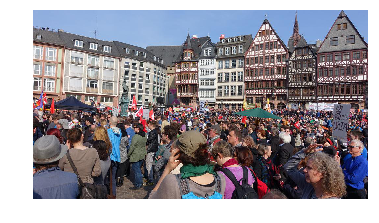

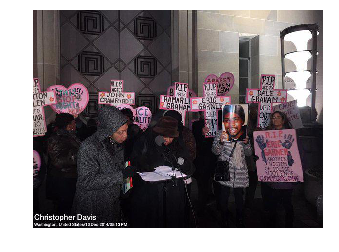

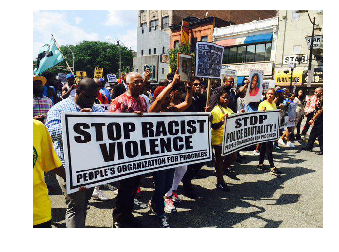

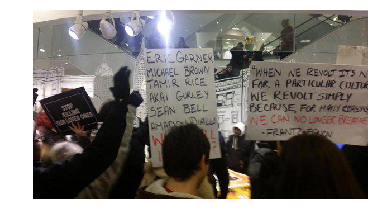

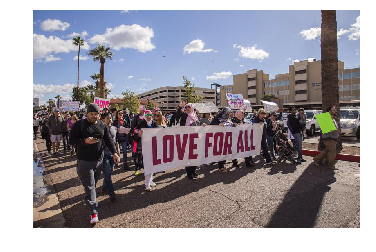

In [40]:
imgs_between_1_2 = df_ITU_UCLA_combined[(df_ITU_UCLA_combined['violence'] <= 0.2) & (df_ITU_UCLA_combined['violence'] >= 0.1) ]

img_paths = imgs_between_1_2['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

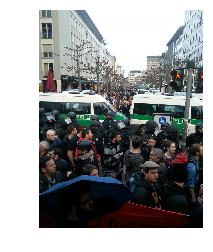

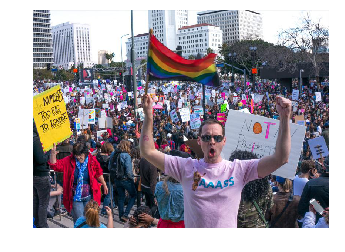

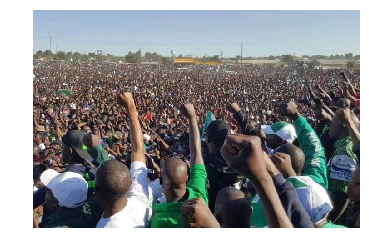

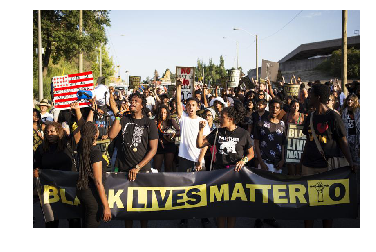

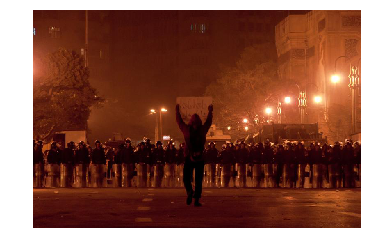

In [43]:
imgs_between_2_3 = df_ITU_UCLA_combined[(df_ITU_UCLA_combined['violence'] <= 0.3) & (df_ITU_UCLA_combined['violence'] >= 0.2) ]

img_paths = imgs_between_2_3['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

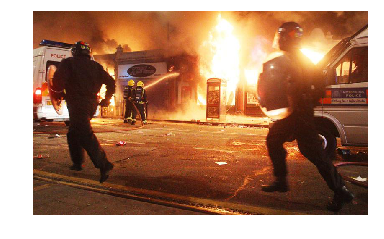

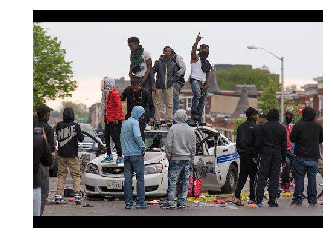

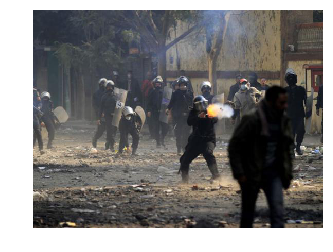

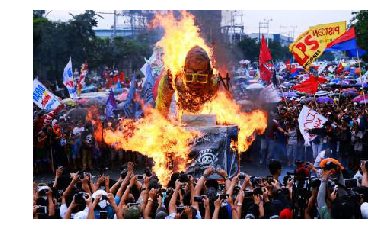

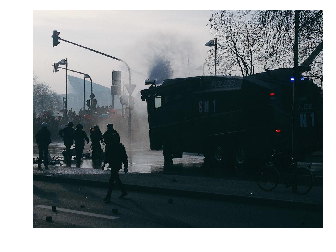

In [44]:
imgs_between_3_4 = df_ITU_UCLA_combined[(df_ITU_UCLA_combined['violence'] <= 0.4) & (df_ITU_UCLA_combined['violence'] >= 0.3) ]

img_paths = imgs_between_3_4['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

 UCLA seems to have its outliers rescaled with a higher order of magnitude than images that were in the bell curve initially.
 

In [52]:
len(df_ITU_UCLA_combined[df_ITU_UCLA_combined['violence'] > 0.43]) / len(df_ITU_UCLA_combined) * 100

0.9874397661742633

Based on the three observations:
* ITU images with scores above 0.43 seem to be very suceptable to if they were or not sampled for the combined data set, while images with lower scores do not seem so. For instance, when an image that initially had a score of .9 was sampled, it changed to .4, while an image with a score of .9 that was not sampled has now .88.
* Visually inspecting, images close to 1, to .6 and to .43 seem to be very similar in their violent content. While images within the bell shape between .1 and .2, .2 and .3, and .3 and .4 seem to have a clear distinction in their violent content
* 8 images out of 125 are from UCLA within the images with scores higher than 0.43. Considering the fact that they have images from search engine searchers such as "riot" and "violent protest", this number seems rather off.

I believe we can say that the images above the threshold of 0.43 (the tail of the distribution visually speaking), are much further to converging to their "truth" scores than the images within the bell shaped distribution. Because of that, they should be taken out of our analysis. In my view, not clipped, but removed.